This exercise uses fake data from a natural movie to pracice obtaining an
STRF using the analytical solution for linear regression, including ridge
regression.

In [1]:
import numpy as np
import mne
import os.path as op
import os
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.signal import convolve
plt.ion()

In [2]:
path_data = op.join('..', 'data')
path_stims = op.join(path_data, 'all_stims')


# Load a 10 x 10 x 20000 natural movie

In [50]:
data = loadmat(op.join(path_data, 'mov.mat'))
movie = data['mov']
movie = movie.transpose([2, 0, 1])
print(movie.shape)

(20000, 10, 10)


In [51]:
mean_stim = movie.mean()
movie = movie - mean_stim

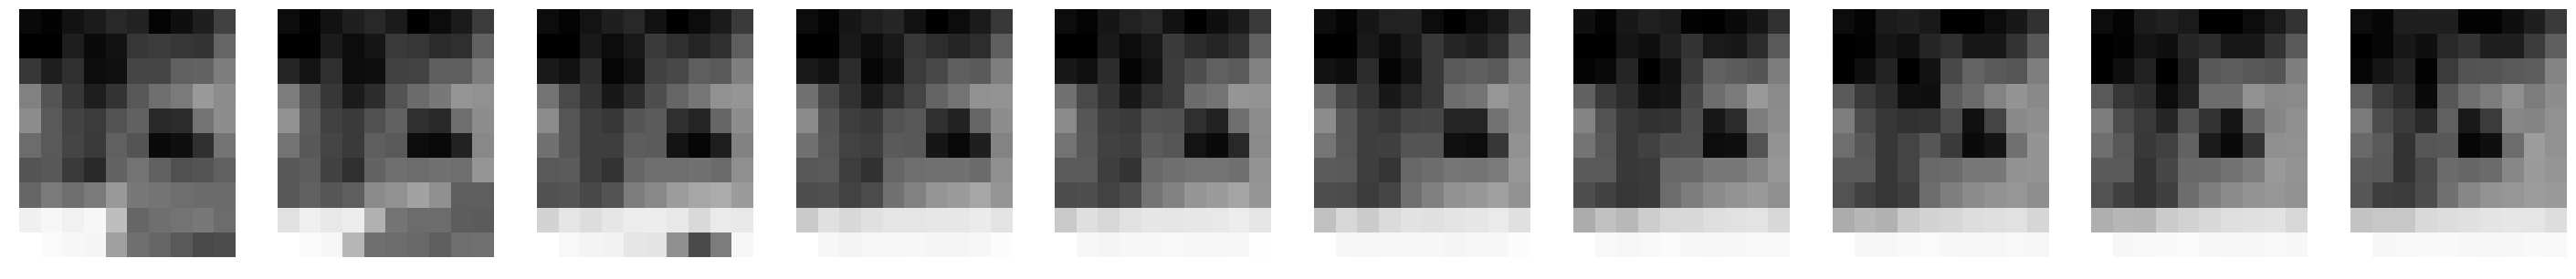

In [52]:
fig, ax = plt.subplots(1, 10, figsize=(5*10, 5))
for ii in range(10):
    ax[ii].imshow(movie[ii], cmap='Greys_r', aspect='auto')
    ax[ii].set_axis_off()

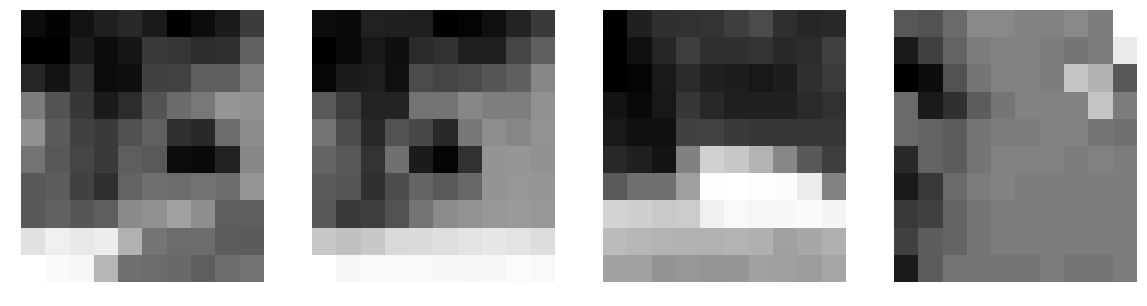

In [53]:
fig, ax = plt.subplots(1, 4, figsize=(4*5, 5))
for ii in range(4):
    ax[ii].imshow(movie[int(10**ii)], cmap='Greys_r', aspect='auto')
    ax[ii].set_axis_off()

# let's create some fake data for a simple cell V1 with a 2D Gabor filter
First we are going to make a Gabor filter

In [54]:
from skimage.filters import gabor, gabor_kernel

In [55]:
from scipy import ndimage as ndi

(10, 10)
(10, 10)


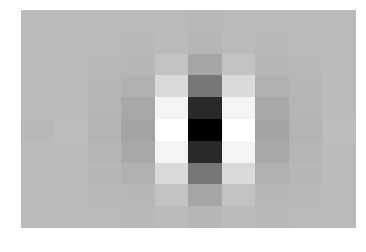

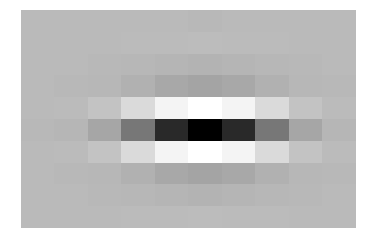

In [129]:
# prepare filter bank kernels
kernels = []
for theta in [0, 90]:
    theta = theta / 4. * np.pi
    for sigma in (1,):
        for frequency in (.4,):
            kernel = np.real(gabor_kernel(frequency, theta=theta, bandwidth=sigma))
            kernel = kernel[:10, :10]
            kernels.append(kernel)

for kernel in kernels:
    print(kernel.shape)
    fig, ax = plt.subplots()
    ax.imshow(kernel, aspect='auto', cmap='Greys')
    ax.set_axis_off()

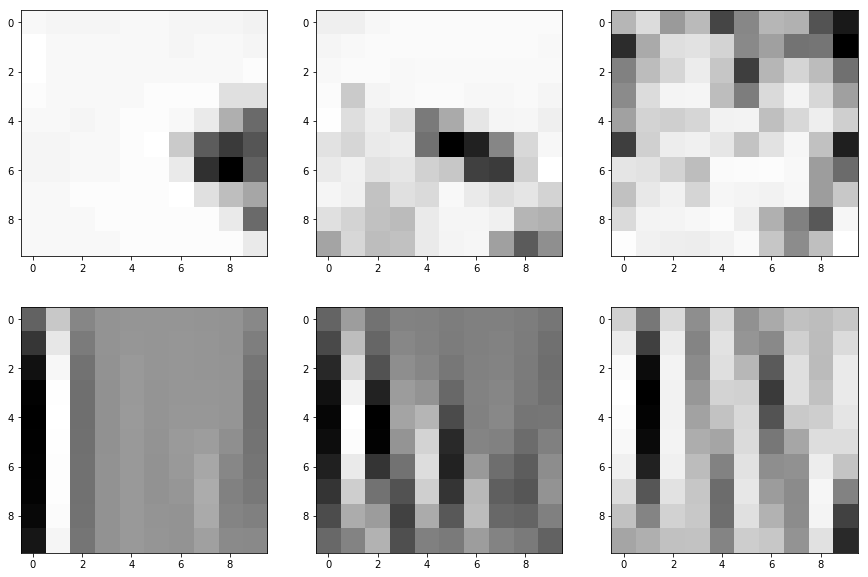

In [143]:
kernel = kernels[0][np.newaxis, :, :]
movie_filtered = convolve(movie, kernel, 'same')

n_plots = 3
fig, axs = plt.subplots(2, n_plots, figsize=(n_plots*5, 2*5))
for ii, ix in enumerate(np.random.randint(0, resp.shape[0], n_plots)):
    axs[0, ii].imshow(movie[ix], cmap='Greys')
    axs[1, ii].imshow(movie_filtered[ix], cmap='Greys')

Convolve the Gabor filter with the stimulus and add Gaussian noise to get a response with an SNR of 1

In [144]:
# Convolve the movie with the filter
kernel = kernels[0]
movie_vec = movie.reshape([movie.shape[0], -1])
resp = np.dot(movie_vec, kernel.ravel())

# Add noise to the response
resp_pow = np.var(resp)
SNR = 10
resp = resp + np.sqrt(resp_pow / SNR) * np.random.randn(len(resp), *resp.shape[1:])

# now we're going to get estimate the gabor using the analytical solution. the stimulus and response

First cross-correlate the response and the stimulus. In this case there is no time component.

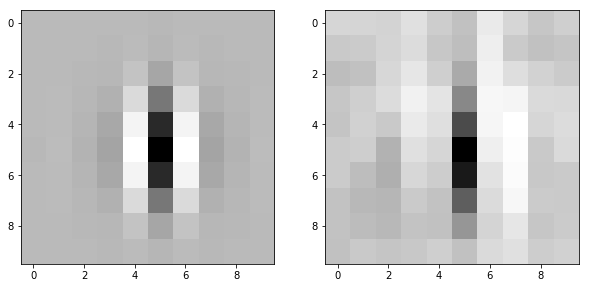

In [150]:
cross_stim_response = np.dot(movie_vec.T, resp) / movie_vec.shape[0]
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
for ax, out in zip(axs, [kernel, cross_stim_response.reshape([10, 10])]):
    ax.imshow(out, 'Greys')

Now calculate the stimulus auto-correlation and image it.

In [159]:
mean_auto_corr = np.zeros([100, 100]);
for it in range(resp.shape[0]):
    this_vec = movie_vec[it][:, np.newaxis]
    auto_corr = np.dot(this_vec, this_vec.T)
    mean_auto_corr += auto_corr
mean_auto_corr /= resp.shape[0]

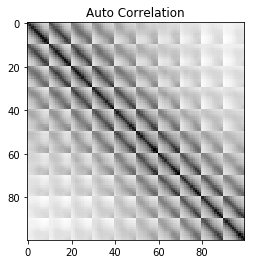

In [160]:
fig, ax = plt.subplots()
ax.imshow(mean_auto_corr, cmap='Greys')
ax.set(title='Auto Correlation')

Now normalize the cross-correlation by the auto-correlation to recover the filter

Try first using the matrix division operator

In [167]:
myfilter = np.dot(np.linalg.inv(mean_auto_corr), cross_stim_response).reshape([10, 10])

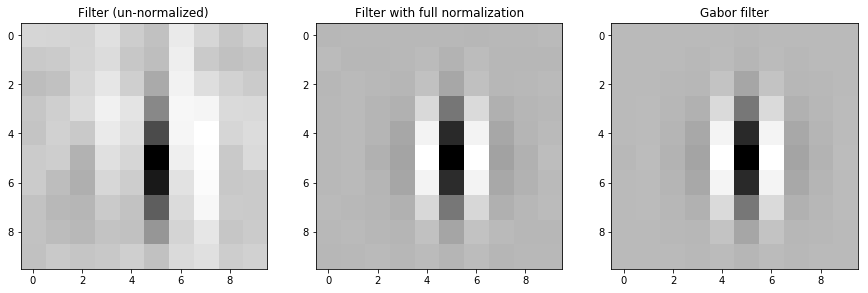

In [170]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
labels = ['Filter (un-normalized)', 'Filter with full normalization', 'Gabor filter']
for ax, im, lab in zip(axs, [cross_stim_response.reshape([10, 10]), myfilter, kernel], labels):
    ax.imshow(im, cmap='Greys')
    ax.set(title=lab)


# Then try using the PCA Regression

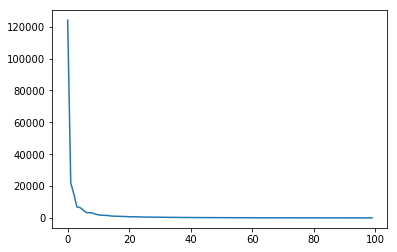

In [177]:
u, s, v = np.linalg.svd(mean_auto_corr)
fig, ax = plt.subplots()
ax.plot(s);

In [245]:
# Let's try dividing into the subspace of 10, 20, and 50
subspaces = [10, 20, 50, 100]
out_filters = {}
for subspace in subspaces:
    s_i = s.copy()
    s_i = 1. / s_i
    s_i[subspace:] = 0
    s_diag = np.diag(s_i)
    out_filters[subspace] = u @ s_diag @ (v @ cross_stim_response)

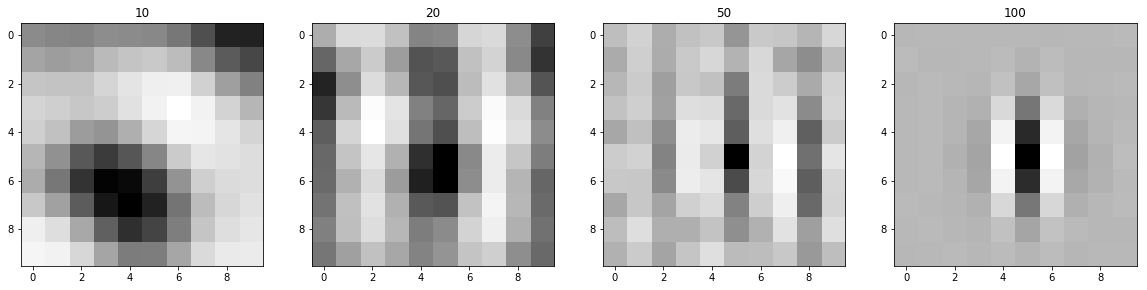

In [246]:
n_plots = len(subspaces)
fig, axs = plt.subplots(1, n_plots, figsize=(5*n_plots, 5))
for ax, (key, val) in zip(axs, out_filters.items()):
    ax.imshow(val.reshape([10, 10]), cmap='Greys')
    ax.set(title='{}D Normalization'.format(key))

Repeat the previous section using eigen value decompostion. The eig command in matlab
does not necessarily sort the eigenvalues - use sort() to get then in descending order.

In [275]:
d, v_eigen = np.linalg.eig(mean_auto_corr)

In [279]:
out_filters_eig = {}
for subspace in subspaces:
    d_i = d.copy()
    d_i = 1. / d_i
    d_i[subspace:] = 0
    d_diag = np.diag(d_i)
    out_filters_eig[subspace] = v_eigen @ d_diag @ (v_eigen.T @ cross_stim_response)

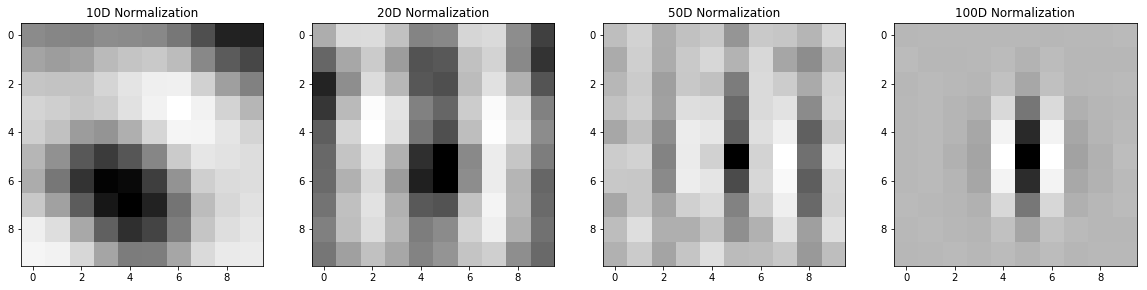

In [280]:
n_plots = len(subspaces)
fig, axs = plt.subplots(1, n_plots, figsize=(5*n_plots, 5))
for ax, (key, val) in zip(axs, out_filters_eig.items()):
    ax.imshow(val.reshape([10, 10]), cmap='Greys')
    ax.set(title='{}D Normalization'.format(key))

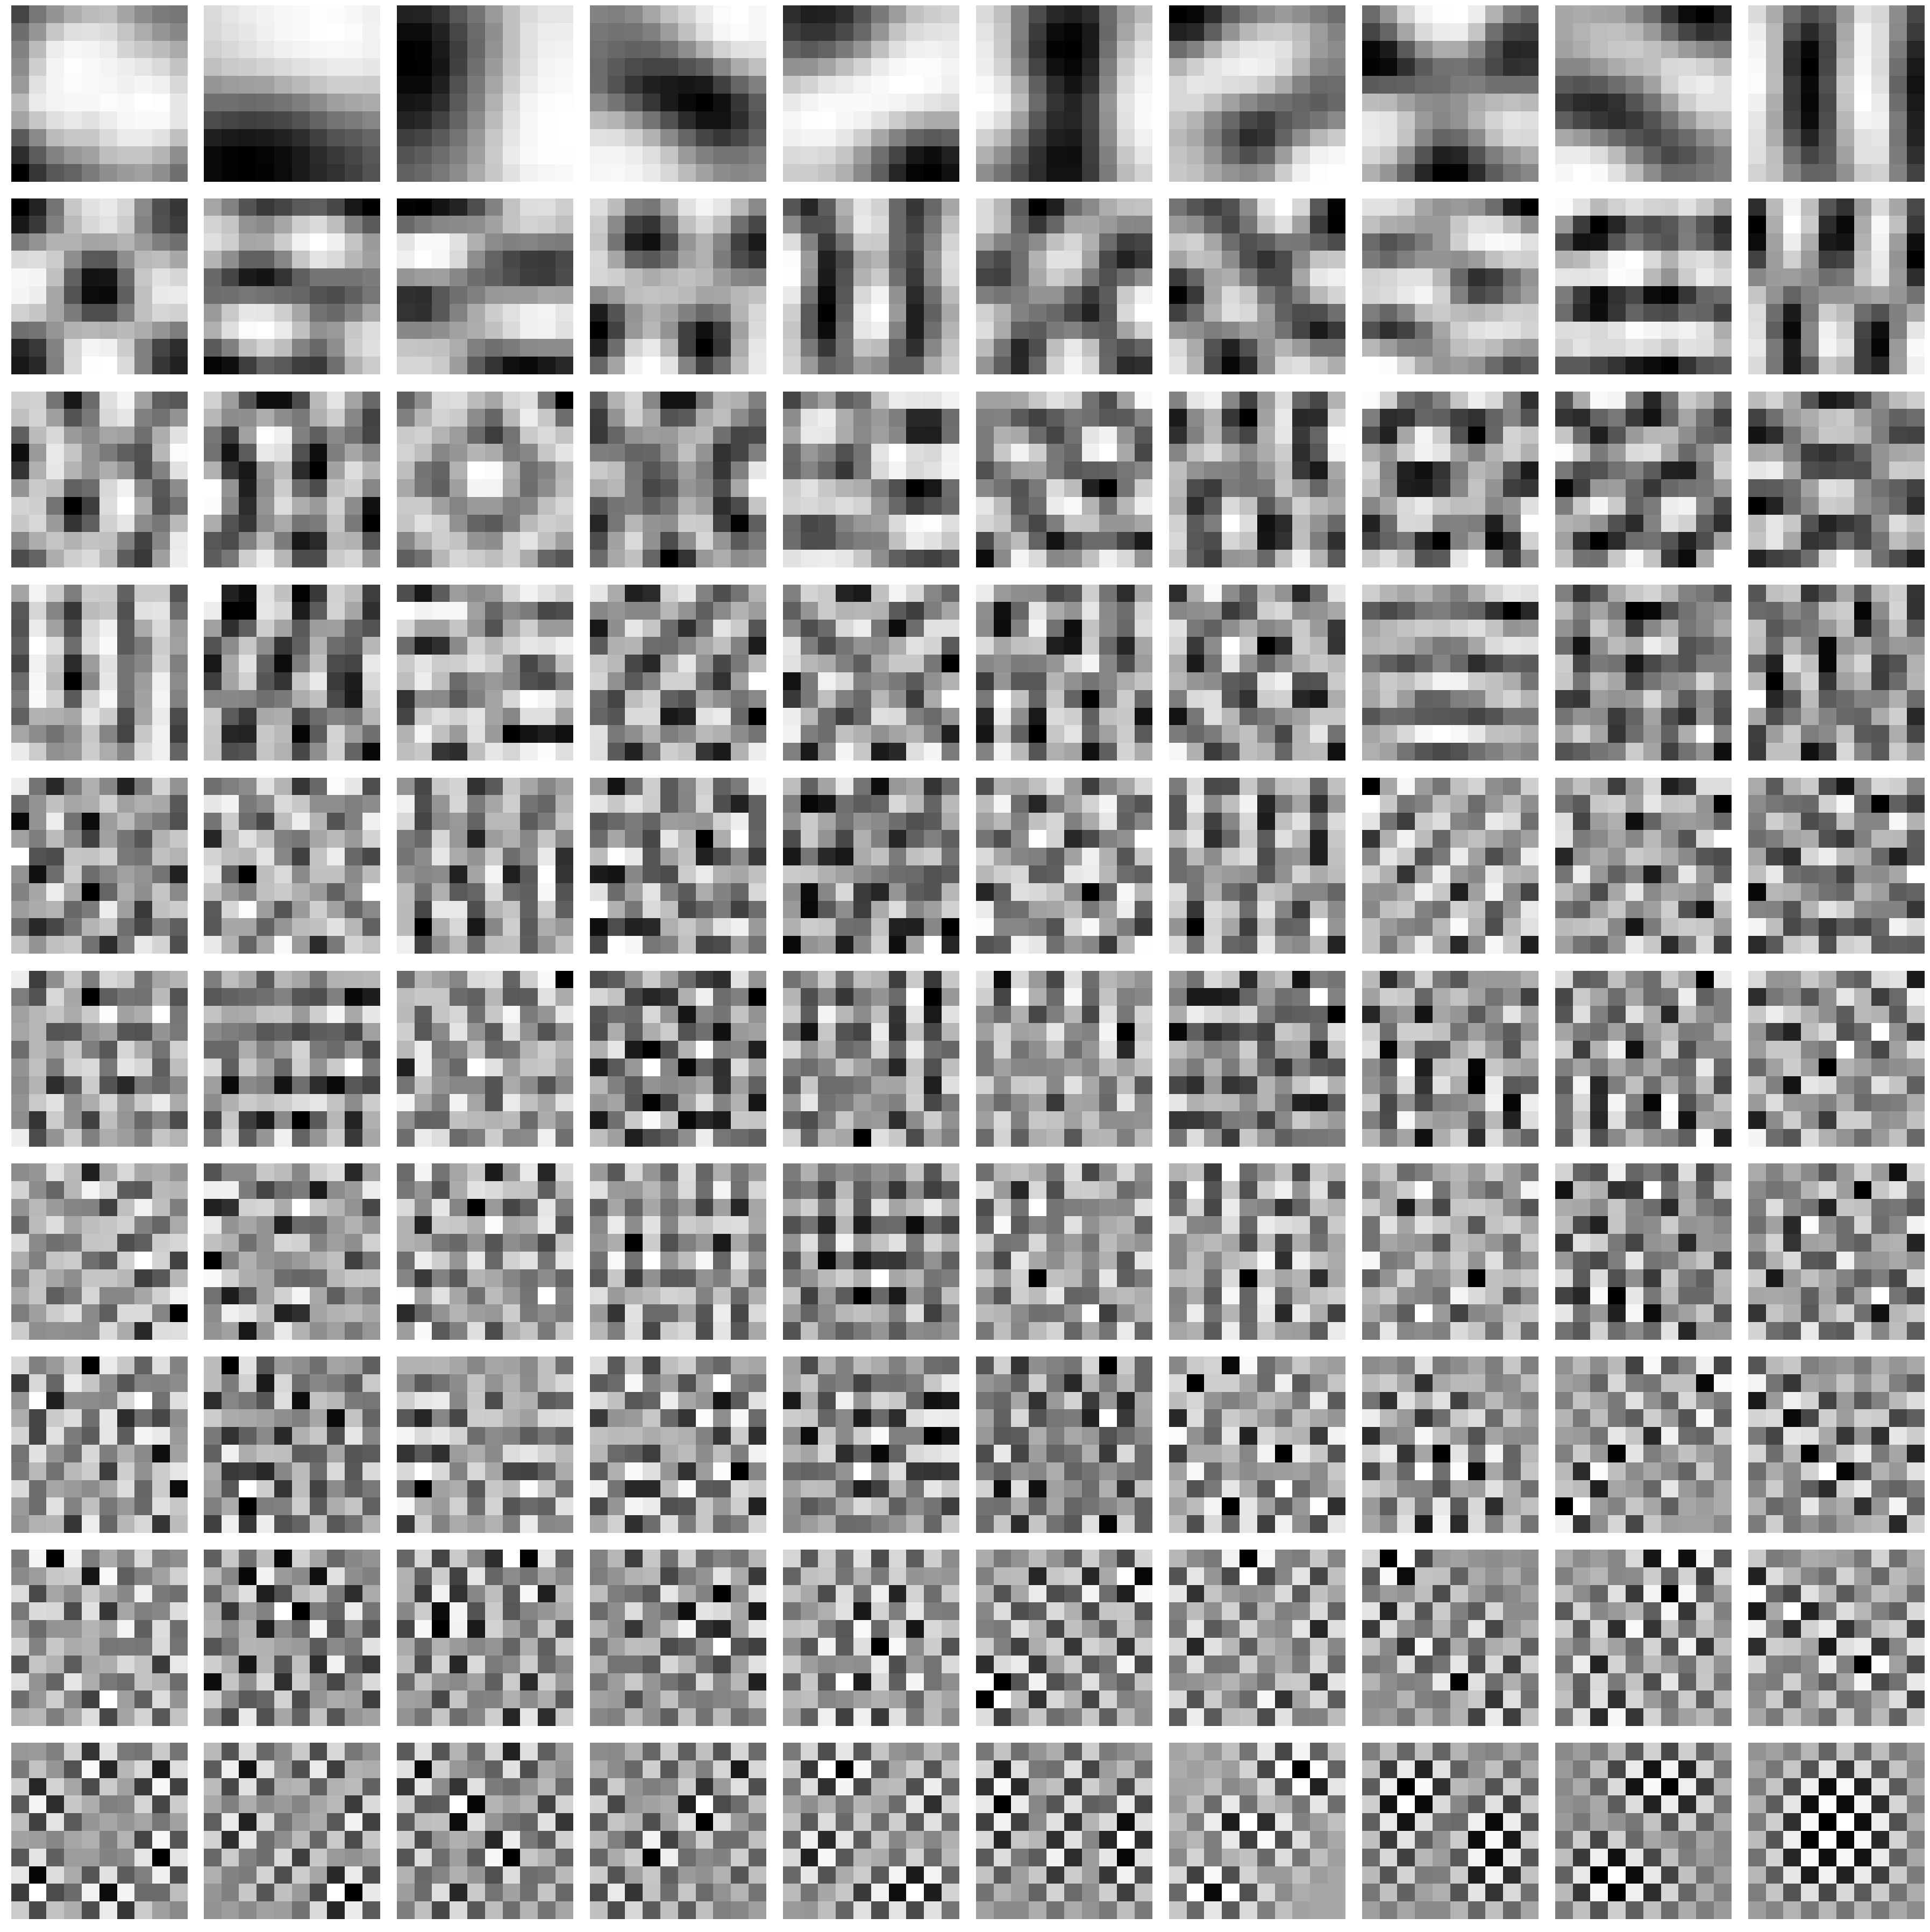

In [285]:
n_row = int(np.ceil(np.sqrt(u.shape[0])))
fig, axs = plt.subplots(n_row, n_row, figsize=(n_row * 5, n_row * 5))
for ax, row in zip(axs.ravel(), u.T):
    ax.imshow(row.reshape([10, 10]), cmap='Greys')
    ax.set_axis_off()
plt.tight_layout()

Finally, we are going to repeat the normalization in the Fourier domain.

First calculate the Fourier Transform of the cross-correlation and auto correlation function. You should do this calculation in the 10x10 space and for the auto correlation, you can either reshape and average the 100x100 auto-correlation function or recalculate the power spectrum of the image. You can then divide the cross-correlation by the auto-correlation in the Fourier domain. Finally take the inverse FFT to get back the filter. Did it give exactly the same result?

In [301]:
stim_pow = np.zeros(movie[0].shape)
for it in range(movie.shape[0]):
    stim_fft = np.fft.fft2(movie[it]);
    stim_pow = stim_pow + (stim_fft * np.conj(stim_fft))

stim_pow /= movie[0].shape[0]

# XXX this bit doesn't look right

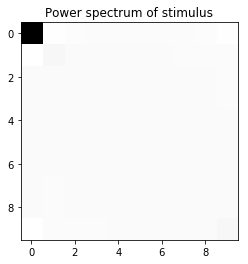

In [302]:
fig, ax = plt.subplots()
ax.imshow(np.real(stim_pow), cmap='Greys')
ax.set(title='Power spectrum of stimulus')